In [12]:
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from eeg_emg_load import load_emg_eeg_data, butter_bandpass_filter, epoch, plot_epochs
from model_utils import train_LDA, train_RFs, train_SVM, train_HTNet, balance_data  #fold_split_

# Load in the EEG and EMG data

In [13]:
path = 'G:/.shortcut-targets-by-id/16bjLJ-x3DCMytjvubbbvXEirA9t2l2q-/FinalProjectData';

eeg_folder = 'EEG'
eeg_file = 'EEG_session1_sub1_multigrasp_realMove.mat'

emg_folder = 'EMG_ConvertedData'
emg_file = 'EMG_session1_sub1_multigrasp_realMove.mat'

# Load data in
emg_data, emg_fs, emg_event_times, emg_grasp_labels, emg_grasp_names = load_emg_eeg_data(os.path.join(path,emg_folder, emg_file));
eeg_data, eeg_fs, eeg_event_times, eeg_grasp_labels, eeg_grasp_names = load_emg_eeg_data(os.path.join(path,eeg_folder, eeg_file));

In [14]:
# Apply butter bandpass filter
emg_data = butter_bandpass_filter(emg_data, 8, 30, emg_fs, order=5)
eeg_data = butter_bandpass_filter(eeg_data, 8, 30, emg_fs, order=5)

In [15]:
# Break into epochs
emg_epochs = epoch(emg_data,emg_event_times, emg_fs, 1);
eeg_epochs = epoch(eeg_data,eeg_event_times, eeg_fs, 1);

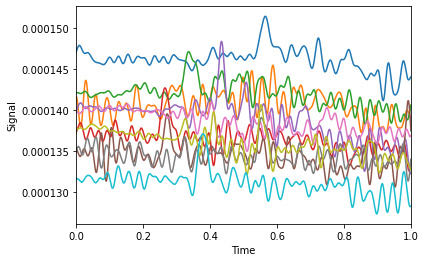

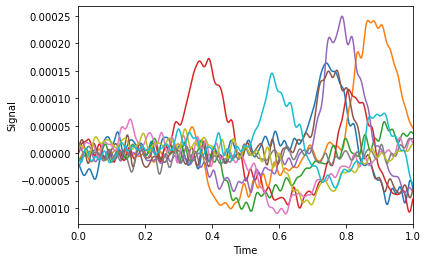

In [16]:
# Plot epochs
plot_epochs(emg_epochs, emg_fs, 1, 10) # First number is number of channels, Second number is number of epochs
plot_epochs(eeg_epochs, eeg_fs, 1, 10) # First number is number of channels, Second number is number of epochs

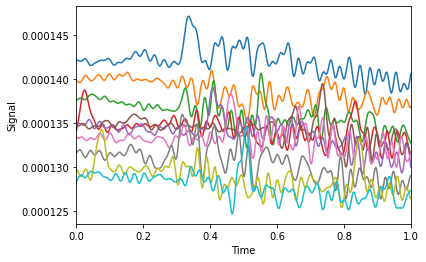

In [17]:
" Now let's see if we can plot the subset for a specified label"
plot_epochs(emg_epochs[:,:,emg_grasp_labels == 3], emg_fs, 1, 10)

In [18]:
# samples, channels, num events
emg_epochs.shape

(2500, 7, 300)

In [19]:
eeg_grasp_names = [i[0] for i in eeg_grasp_names]
eeg_grasp_names

['Cylindrical', 'Spherical', 'Lumbrical', 'Rest']

In [20]:
# Check to see if the EMG and EEG grasp labels match
np.all(emg_grasp_labels == eeg_grasp_labels)

True

In [21]:
trimmed_grasp_labels, trimmed_emg_epochs, trimmed_eeg_epochs = balance_data(emg_grasp_labels, emg_epochs, eeg_epochs)

[2. 3. 1. 3. 3. 2. 4. 3. 2. 4. 2. 1. 3. 3. 1. 1. 2. 4. 1. 4. 3. 2. 1. 1.
 2. 4. 2. 4. 1. 1. 3. 3. 4. 2. 3. 4. 1. 4. 3. 3. 4. 3. 2. 1. 3. 4. 2. 2.
 1. 3. 3. 4. 1. 4. 1. 4. 1. 4. 2. 1. 2. 1. 4. 3. 1. 3. 4. 1. 3. 3. 4. 1.
 3. 3. 4. 3. 2. 1. 2. 1. 1. 2. 2. 4. 3. 1. 1. 4. 1. 4. 2. 2. 4. 3. 1. 1.
 4. 1. 4. 2. 2. 2. 3. 1. 4. 3. 4. 2. 2. 4. 1. 3. 4. 3. 4. 2. 1. 4. 3. 3.
 4. 1. 3. 3. 2. 3. 2. 3. 1. 2. 3. 4. 2. 2. 4. 2. 1. 1. 1. 4. 2. 4. 2. 3.
 3. 3. 4. 1. 1. 1. 3. 2. 2. 1. 1. 4. 1. 2. 4. 2. 4. 2. 3. 3. 3. 2. 3. 2.
 2. 1. 4. 1. 4. 3. 2. 2. 1. 2. 3. 4. 2. 2. 4. 3. 2. 4. 1. 4. 2. 4. 2. 4.
 1. 3. 4. 1. 3. 1. 3. 4.]
(2500, 7, 200)
(2500, 7, 200)
(array([1., 2., 3., 4.]), array([50, 50, 50, 50], dtype=int64))


In [22]:

x_train = trimmed_emg_epochs[:,:,0:50]
x_test = trimmed_emg_epochs[:,:,50:trimmed_grasp_labels.shape[0]]
y_train = trimmed_grasp_labels[0:50]
y_test = trimmed_grasp_labels[50:trimmed_grasp_labels.shape[0]]
# Reshape x_train y swapping axes
x_train = np.swapaxes(x_train, 0, 2)
x_test = np.swapaxes(x_test, 0, 2)
# X needs to be of shape (n_epochs, n_channels, n_times)
# Y needs to be shape (n_epochs,)

y_train

array([2., 3., 1., 3., 3., 2., 4., 3., 2., 4., 2., 1., 3., 3., 1., 1., 2.,
       4., 1., 4., 3., 2., 1., 1., 2., 4., 2., 4., 1., 1., 3., 3., 4., 2.,
       3., 4., 1., 4., 3., 3., 4., 3., 2., 1., 3., 4., 2., 2., 1., 3.])

In [23]:
from mne.decoding import CSP # Import CSP
#https://mne.tools/stable/generated/mne.decoding.CSP.html#mne.decoding.CSP.fit
                    
csp = CSP(n_components = 4, transform_into = 'csp_space') # Initate CSP
csp.fit(x_train,y_train) # Fit CSP using training data
params = csp.get_params # Get parameters in case we want to see them
# plot CSP patterns estimated on full data for visualization
X_train = csp.transform(x_train) # Transform the training set
X_test = csp.transform(x_test) # Transform the test set

Computing rank from data with rank=None
    Using tolerance 0.23 (2.2e-16 eps * 7 dim * 1.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.23 (2.2e-16 eps * 7 dim * 1.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.26 (2.2e-16 eps * 7 dim * 1.7e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.22 (2.2e-16 eps * 7 dim * 1.4e+14  max singular value)
    Estimated rank (mag): 7
   

In [24]:
np.shape(X_train)

(50, 4, 2500)

In [51]:
def feature_extract_csp(x_train,y_train, x_test, n_components):
    """
    Input: 
    
    x_train: array (n_epochs, n_channels, n_times)
            Array with the trainining data
            
    y_train: array (n_epochs,)
            Array with the event labels
            
    x_test:  array (n_epochs, n_channels, n_times)
            Array with the test data
            
    n_componenets: Integer
            Number of components to calculate. 
    """
    from mne.decoding import CSP # Import CSP
    #https://mne.tools/stable/generated/mne.decoding.CSP.html#mne.decoding.CSP.fit         
    csp = CSP(n_components = n_components, transform_into = 'csp_space') # Initate CSP
    csp.fit(x_train,y_train) # Fit CSP using training data
    params = csp.get_params # Get parameters in case we want to see them
    # plot CSP patterns estimated on full data for visualization
    X_train = csp.transform(x_train) # Transform the training set
    X_test = csp.transform(x_test) # Transform the test set
    
    return X_train, X_test

In [53]:
X_train, X_test = feature_extract_csp(x_train, y_train, x_test,4)

Computing rank from data with rank=None
    Using tolerance 0.23 (2.2e-16 eps * 7 dim * 1.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.23 (2.2e-16 eps * 7 dim * 1.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.25 (2.2e-16 eps * 7 dim * 1.6e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.22 (2.2e-16 eps * 7 dim * 1.4e+14  max singular value)
    Estimated rank (mag): 7
   

(150, 4)